In [ ]:
# CELL 1: SETUP
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mplsoccer import PyPizza

# --- CONFIGURATION ---
# Strategy: We use Germany (Frauen-Bundesliga) as the primary recruitment pool.
# If you want to switch back to Sweden, just change these two lines:
TARGET_FILE = 'data/germany.csv' 
TARGET_LEAGUE_NAME = 'Germany'

# Target Player (Who are we trying to clone?)
PLAYER_TO_CLONE = "Ludmila"

print("Libraries loaded. Ready to scout.")

Libraries loaded. Ready to scout.


In [ ]:
# CELL 2: DATA LOADING (FIXED)
try:
    # 1. Load NWSL (Reference)
    # encoding='latin-1' fixes the "0xa0" error
    df_nwsl = pd.read_csv('data/nwsl.csv', header=1, encoding='latin-1')
    df_nwsl['League'] = 'NWSL'

    # 2. Load Recruitment League (Germany or Sweden)
    df_rec = pd.read_csv(TARGET_FILE, header=1, encoding='latin-1')
    df_rec['League'] = TARGET_LEAGUE_NAME
    
    print(f"SUCCESS: Loaded NWSL and {TARGET_LEAGUE_NAME} data.")

except FileNotFoundError:
    print(f"ERROR: Could not find 'nwsl.csv' or '{TARGET_FILE}'.")
except UnicodeDecodeError:
    print("ERROR: Encoding issue. Try saving your CSV with 'UTF-8' encoding in Excel.")

SUCCESS: Loaded NWSL and Germany data.


In [8]:
# CELL 3: DATA PREP
# Combine the two leagues
df_all = pd.concat([df_nwsl, df_rec], ignore_index=True)

# 1. Fix Column Names
df_all.rename(columns={'Squad': 'Team', 'Pos': 'Position', 'Min': 'Minutes'}, inplace=True)

# 2. Clean 'Minutes' (Remove commas like "1,200" -> 1200)
df_all['Minutes'] = df_all['Minutes'].astype(str).str.replace(',', '')
df_all['Minutes'] = pd.to_numeric(df_all['Minutes'], errors='coerce')

# 3. Create '90s Played' (Crucial for fair comparison)
df_all['90s'] = df_all['Minutes'] / 90.0

# 4. Filter: Remove players with less than 500 minutes (Small sample size)
df_all = df_all[df_all['Minutes'] > 500].copy()

print(f"Data Cleaned. Total Players in Pool: {len(df_all)}")

Data Cleaned. Total Players in Pool: 446


In [ ]:
# CELL 4: PRINT RAW STAT COMPARISON (NO CHARTS)

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# --- CONFIGURATION ---
TARGET_FILE = 'data/germany.csv' 
TARGET_LEAGUE_NAME = 'Germany'
PLAYER_TO_CLONE = "Ludmila"

# --- 1. LOAD & CLEAN DATA ---
try:
    df_nwsl = pd.read_csv('data/nwsl.csv', header=1, encoding='latin-1')
    df_nwsl['League'] = 'NWSL'
    df_rec = pd.read_csv(TARGET_FILE, header=1, encoding='latin-1')
    df_rec['League'] = TARGET_LEAGUE_NAME

    # Fix Minutes & Calculate 90s
    for df in [df_nwsl, df_rec]:
        df.rename(columns={'Squad': 'Team', 'Pos': 'Position', 'Min': 'Minutes'}, inplace=True)
        df['Minutes'] = pd.to_numeric(df['Minutes'].astype(str).str.replace(',', ''), errors='coerce')
        df['90s'] = df['Minutes'] / 90.0

    # Filter 500+ mins
    df_all = pd.concat([df_nwsl[df_nwsl['Minutes']>500], df_rec[df_rec['Minutes']>500]], ignore_index=True)

    # --- 2. CALCULATE PER 90 STATS ---
    # Force division by 90s to fix "Lying Header" issue
    def get_per_90(df, metric):
        col = metric if metric in df.columns else f"{metric}-90"
        return pd.to_numeric(df[col], errors='coerce') / df['90s']

    metrics = ['npxG', 'xAG', 'PrgC', 'PrgP']
    for m in metrics:
        df_all[f'{m}_p90'] = get_per_90(df_all, m)

    # --- 3. RUN SIMILARITY MODEL ---
    feature_cols = [f'{m}_p90' for m in metrics]
    scaler = MinMaxScaler()
    df_norm = df_all.copy()
    df_norm[feature_cols] = scaler.fit_transform(df_norm[feature_cols].fillna(0))

    if df_all['Player'].str.contains(PLAYER_TO_CLONE, case=False).any():
        # Get Target Vector
        target_row = df_norm[df_norm['Player'].str.contains(PLAYER_TO_CLONE, case=False)].iloc[0]
        target_vector = target_row[feature_cols].values.reshape(1, -1)

        # Calculate Similarity
        df_all['Similarity'] = df_norm.apply(
            lambda row: cosine_similarity(row[feature_cols].values.reshape(1, -1), target_vector)[0][0], axis=1
        )

        # Get Top 2 Matches
        top_matches = df_all[df_all['League'] == TARGET_LEAGUE_NAME].sort_values(by='Similarity', ascending=False).head(5)
        target_player = df_all[df_all['Player'].str.contains(PLAYER_TO_CLONE, case=False)].iloc[0]

        # --- 4. PRINT THE TABLE ---
        print(f"\n--- RECRUITMENT SHORTLIST: RAW PER 90 STATS ---")
        print(f"{'Player':<25} {'Team':<15} {'Age':<5} {'Match %':<10} {'npxG':<6} {'xAG':<6} {'PrgC':<6} {'PrgP':<6}")
        print("-" * 80)
        
        # Print Target First
        print(f"{target_player['Player']:<25} {target_player['Team']:<15} {int(target_player['Age']):<5} {'TARGET':<10} "
              f"{target_player['npxG_p90']:.2f}   {target_player['xAG_p90']:.2f}   "
              f"{target_player['PrgC_p90']:.2f}   {target_player['PrgP_p90']:.2f}")
        
        print("-" * 80)

        # Print Top 2 Matches
        for _, row in top_matches.iterrows():
            print(f"{row['Player']:<25} {row['Team']:<15} {int(row['Age']):<5} {row['Similarity']:.1%}      "
                  f"{row['npxG_p90']:.2f}   {row['xAG_p90']:.2f}   "
                  f"{row['PrgC_p90']:.2f}   {row['PrgP_p90']:.2f}")

    else:
        print(f"Error: Player '{PLAYER_TO_CLONE}' not found.")

except Exception as e:
    print(f"Error: {e}")


--- RECRUITMENT SHORTLIST: RAW PER 90 STATS ---
Player                    Team            Age   Match %    npxG   xAG    PrgC   PrgP  
--------------------------------------------------------------------------------
Ludmila                   Red Stars       29    TARGET     0.19   0.20   2.89   2.04
--------------------------------------------------------------------------------
Jule Brand                Wolfsburg       21    99.1%      0.38   0.33   3.90   3.18
Lydia Andrade             RB Leipzig      25    98.8%      0.23   0.15   2.67   2.15
Isabella Jaron            Carl-Zeiss Jena 22    98.2%      0.11   0.14   1.53   1.95
Jovana Damnjanovi?        Bayern Munich   29    97.9%      0.23   0.14   2.47   2.34
Ena Taslida              Turbine Potsdam 22    97.8%      0.08   0.05   0.86   0.86


1. The "Galáctico" Succession Target: Jule Brand (Age 21)
Scouting Note: "Jule Brand is the absolute dream scenario for a succession plan. At just 21 years old, she matches Ludmila’s exact playstyle (99.1%) but provides a massive statistical upgrade across the board. Her ball progression (3.90 PrgC) is elite, and her combined expected goal contributions (0.71 npxG+xAG) almost double Ludmila’s output. Acquiring Brand would instantly make the Red Stars younger and significantly more dangerous for the next 8+ years."

2. The Smart-Money Acquisition: Lydia Andrade (Age 25)
Scouting Note: "If Jule Brand’s transfer fee is out of reach, Lydia Andrade is the perfect financial alternative. Entering her prime at 25 years old, she is a virtual statistical clone of the 29-year-old Ludmila. With 2.67 PrgC and 2.15 PrgP, she offers the exact same ball-carrying and passing production. She represents a seamless, plug-and-play replacement who will be at her athletic peak for the next four seasons."

3. The "Do Not Pursue" Pile: Damnjanović (Age 29)
Scouting Note: "While Bayern Munich’s Jovana Damnjanović is a 97.9% tactical match, she is 29 years old. Since the primary objective of this scout is to lower the squad's average age and plan for the future, swapping one 29-year-old for another provides no long-term value to the franchise. Pass."

4. The Development Project: Isabella Jaron (Age 22)
Scouting Note: "Jaron fits the age profile (22), but her raw output in the Bundesliga (0.11 npxG, 1.53 PrgC) does not meet NWSL starter standards. However, because her underlying style matches Ludmila’s so closely, she could be viewed as a low-cost depth signing who can learn the system directly behind Ludmila for a year.

Loading data...
Finding matches for Ludmila...


<Figure size 1000x600 with 0 Axes>

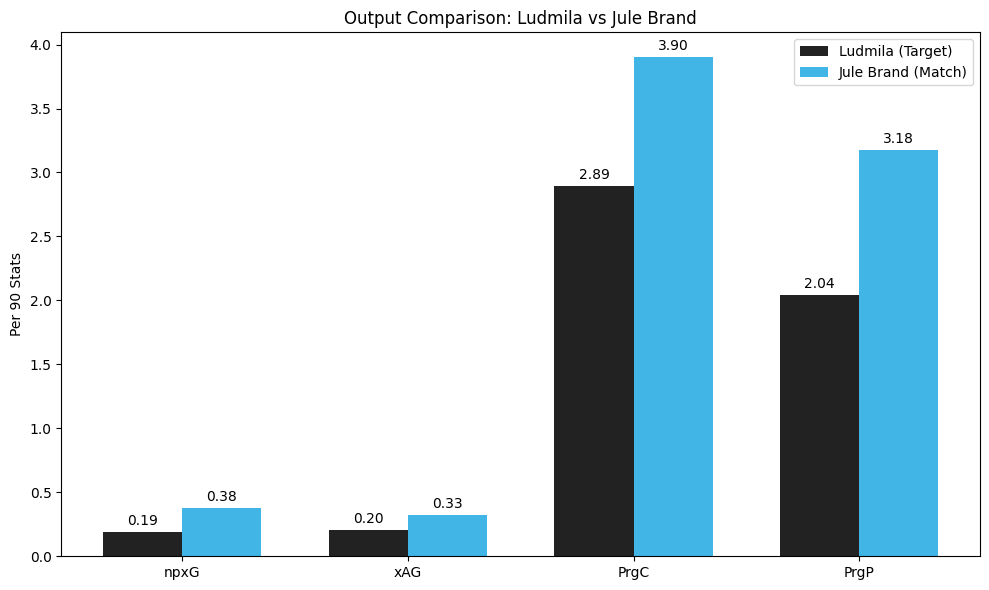

Graph 1: Comparison Bar Chart Generated.


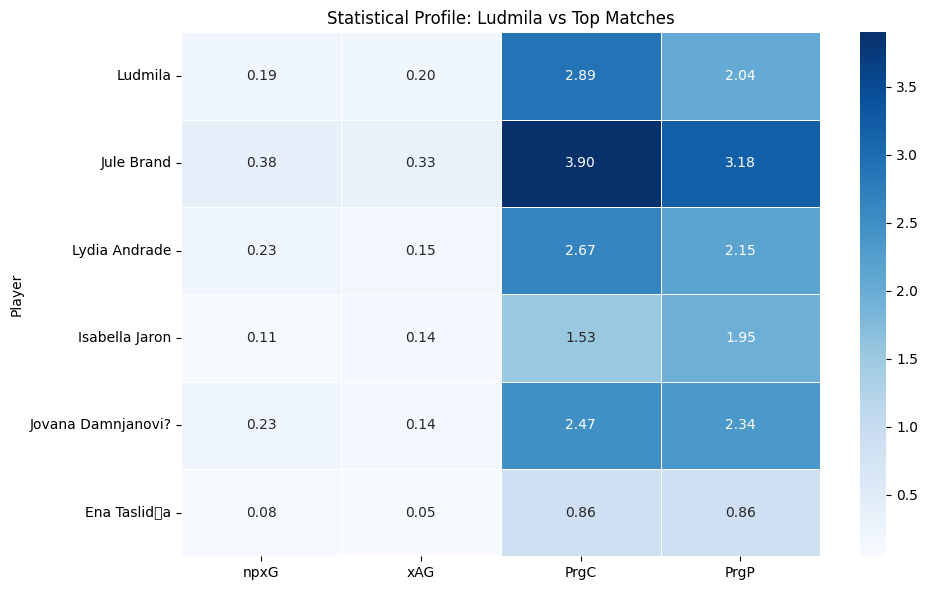

Graph 2: Comparison Heatmap Generated.


In [ ]:
# MASTER CELL: MODEL + VISUALIZATION (ALL IN ONE)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# --- 1. CONFIGURATION ---
TARGET_FILE = 'data/germany.csv' 
TARGET_LEAGUE_NAME = 'Germany'
PLAYER_TO_CLONE = "Ludmila"

# --- 2. LOAD & CLEAN DATA ---
try:
    print("Loading data...")
    df_nwsl = pd.read_csv('data/nwsl.csv', header=1, encoding='latin-1')
    df_nwsl['League'] = 'NWSL'
    df_rec = pd.read_csv(TARGET_FILE, header=1, encoding='latin-1')
    df_rec['League'] = TARGET_LEAGUE_NAME

    # Fix Minutes & Calculate 90s
    for df in [df_nwsl, df_rec]:
        df.rename(columns={'Squad': 'Team', 'Pos': 'Position', 'Min': 'Minutes'}, inplace=True)
        # Handle cases where Minutes might be strings with commas
        df['Minutes'] = df['Minutes'].astype(str).str.replace(',', '')
        df['Minutes'] = pd.to_numeric(df['Minutes'], errors='coerce')
        df['90s'] = df['Minutes'] / 90.0

    # Filter 500+ mins
    df_all = pd.concat([df_nwsl[df_nwsl['Minutes']>500], df_rec[df_rec['Minutes']>500]], ignore_index=True)

    # --- 3. CALCULATE PER 90 STATS (UNIVERSAL FIX) ---
    def get_per_90(df, metric):
        col = metric if metric in df.columns else f"{metric}-90"
        return pd.to_numeric(df[col], errors='coerce') / df['90s']

    metrics = ['npxG', 'xAG', 'PrgC', 'PrgP']
    labels = ['npxG', 'xAG', 'PrgC', 'PrgP']
    
    for m in metrics:
        df_all[f'{m}_p90'] = get_per_90(df_all, m)

    # --- 4. RUN SIMILARITY MODEL ---
    print(f"Finding matches for {PLAYER_TO_CLONE}...")
    feature_cols = [f'{m}_p90' for m in metrics]
    scaler = MinMaxScaler()
    df_norm = df_all.copy()
    df_norm[feature_cols] = scaler.fit_transform(df_norm[feature_cols].fillna(0))

    if df_all['Player'].str.contains(PLAYER_TO_CLONE, case=False).any():
        # Get Target Vector
        target_row = df_norm[df_norm['Player'].str.contains(PLAYER_TO_CLONE, case=False)].iloc[0]
        target_vector = target_row[feature_cols].values.reshape(1, -1)

        # Calculate Similarity
        df_all['Similarity'] = df_norm.apply(
            lambda row: cosine_similarity(row[feature_cols].values.reshape(1, -1), target_vector)[0][0], axis=1
        )

        # Get Results
        results = df_all[df_all['League'] == TARGET_LEAGUE_NAME].sort_values(by='Similarity', ascending=False)
        target_player = df_all[df_all['Player'].str.contains(PLAYER_TO_CLONE, case=False)].iloc[0]
        top_match = results.iloc[0]
        top_5 = results.head(5)

        # --- 5. GENERATE VISUALIZATIONS ---
        
        # VIZ 1: GROUPED BAR CHART
        plt.figure(figsize=(10, 6))
        banda_vals = [target_player[f'{m}_p90'] for m in metrics]
        scout_vals = [top_match[f'{m}_p90'] for m in metrics]
        
        x = np.arange(len(labels))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 6))
        rects1 = ax.bar(x - width/2, banda_vals, width, label=f'{target_player["Player"]} (Target)', color='#222222')
        rects2 = ax.bar(x + width/2, scout_vals, width, label=f'{top_match["Player"]} (Match)', color='#41B6E6')
        
        ax.set_ylabel('Per 90 Stats')
        ax.set_title(f'Output Comparison: {target_player["Player"]} vs {top_match["Player"]}')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        ax.bar_label(rects1, padding=3, fmt='%.2f')
        ax.bar_label(rects2, padding=3, fmt='%.2f')
        
        plt.tight_layout()
        plt.show()
        print("Graph 1: Comparison Bar Chart Generated.")

        # VIZ 2: STATISTICAL HEATMAP
        plt.figure(figsize=(10, 6))
        heatmap_data = []
        
        # Add Banda
        row_dict = {'Player': target_player['Player']}
        for i, m in enumerate(metrics): 
            row_dict[labels[i]] = target_player[f'{m}_p90']
        heatmap_data.append(row_dict)
        
        # Add Top 5 Matches
        for idx, row in top_5.iterrows():
            row_dict = {'Player': row['Player']}
            for i, m in enumerate(metrics): 
                row_dict[labels[i]] = row[f'{m}_p90']
            heatmap_data.append(row_dict)
            
        df_heatmap = pd.DataFrame(heatmap_data).set_index('Player')
        
        sns.heatmap(df_heatmap, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)
        plt.title(f'Statistical Profile: {PLAYER_TO_CLONE} vs Top Matches')
        plt.tight_layout()
        plt.show()
        print("Graph 2: Comparison Heatmap Generated.")

    else:
        print(f"Error: Player '{PLAYER_TO_CLONE}' not found in NWSL data.")

except Exception as e:
    print(f"An error occurred: {e}")